In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pycatch22 as catch22
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
import sdeint
import pandas as pd
import palettable
import matplotlib as mpl
import plotly.express as px

### Proof of concept for instance space plot
- Low, medium, high noise
- Low (fixed point), hopf bifurcation, limit cycle for hopf system
- Low (fixed point), bistable region, High (fixed point) for bistable system
- Fit Hooke's Potential to the Hopf mu value
- Less samples to avoid convoluting the plot

In [2]:
np.random.seed(0)
num_samples = 50
etas = [0.05, 0.5, 0.8]
mus = [-5, -1, 1, 5]
sols_list = list()
eta_val_hopf = list()
mu_val_hopf = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
for eta in etas:
    for mu in mus:
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x **2 - y**2) * x
            dydt = x + (mu - x ** 2 - y **2) * y
            return dxdt, dydt
        for i in range(num_samples):
            eta_val_hopf.append(eta)
            mu_val_hopf.append(mu)
            ic = np.array(np.random.uniform(size=2)) # uniform random initial conditions
            gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            sols_list.append(sol[500:]) # cut out first 500 time points


In [3]:
TS_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_hopf = np.array([catch22.catch22_all(TS_hopf[i,:])['values'] for i in range(len(sols_list))])

In [4]:
np.random.seed(643)
num_samples = 50 # 49 mins
etas = [0.05, 0.5, 0.8]
mus = [-1, -0.3, 0.3, 1]
sols_list = list()
eta_val_bistable = list()
mu_val_bistable = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
for eta in etas:
    for mu in mus:
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt 
        for i in range(num_samples):
            mu_val_bistable.append(mu)
            eta_val_bistable.append(eta)
            ic = np.array([np.random.uniform()]) # uniform random initial conditions
            gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
            fw = lambda y, t: np.array(f(y,t))
            sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
            sols_list.append(sol[500:]) # cut out first 500 time points
    

In [5]:
TS_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_bistable = np.array([catch22.catch22_all(TS_bistable[i,:])['values'] for i in range(len(sols_list))])

In [6]:
np.random.seed(42)
num_samples = 100
eta = 0.05
mu = -5
eta_val_hookes = list()
mu_val_hookes = list()
sols_list = list()
dt = 0.01
tspan = np.arange(0,55, dt)
for i in range(num_samples):
    eta_val_hookes.append(eta)
    mu_val_hookes.append(mu)
    def f(state, t):
        x = state[0]
        dxdt = mu*x
        return dxdt
    ic = np.array([np.random.uniform()])
    gw = lambda y, t: eta * np.identity(ic.shape[0])
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
    sols_list.append(sol[500:]) # cut out first 500 time points

In [7]:
TS_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_hookes = np.array([catch22.catch22_all(TS_hookes[i,:])['values'] for i in range(len(sols_list))])

In [8]:
FEATURES_COMBINED = np.vstack([FEATURES_bistable, FEATURES_hopf, FEATURES_hookes])

In [9]:
iqr_scaling = RobustScaler().fit_transform(FEATURES_COMBINED)
sigmoidal_iqr = np.zeros(iqr_scaling.shape)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
for feature in range(22):
    x = iqr_scaling[:,feature]
    sigmoidal_iqr[:, feature] = sigmoid(x, 1.35) # theta = 1.35
zscr_sigmoid_iqr = StandardScaler().fit_transform(sigmoidal_iqr)

In [10]:
pca_reducer = PCA(n_components=2)
embedding = pca_reducer.fit_transform(zscr_sigmoid_iqr)

In [11]:
df_bistable = pd.DataFrame(embedding[:600])
df_bistable['mu'] = mu_val_bistable
df_bistable['eta'] = eta_val_bistable
df_bistable['system'] = 'Bistable'
df_hopf = pd.DataFrame(embedding[600:1200])
df_hopf['mu'] = mu_val_hopf
df_hopf['eta'] = eta_val_hopf
df_hopf['system'] = 'Hopf'
df_hookes = pd.DataFrame(embedding[1200:])
df_hookes['mu'] = mu_val_hookes
df_hookes['eta'] = eta_val_hookes
df_hookes['system'] = 'Hookes'
df = pd.concat([df_bistable, df_hopf, df_hookes])

In [21]:
hopf_trace = df[df['system'] == 'Hopf']
hookes_trace = df[df['system'] == 'Hookes']
bistable_trace = df[df['system'] == 'Bistable']

In [23]:
plt.style.use('dark_background')

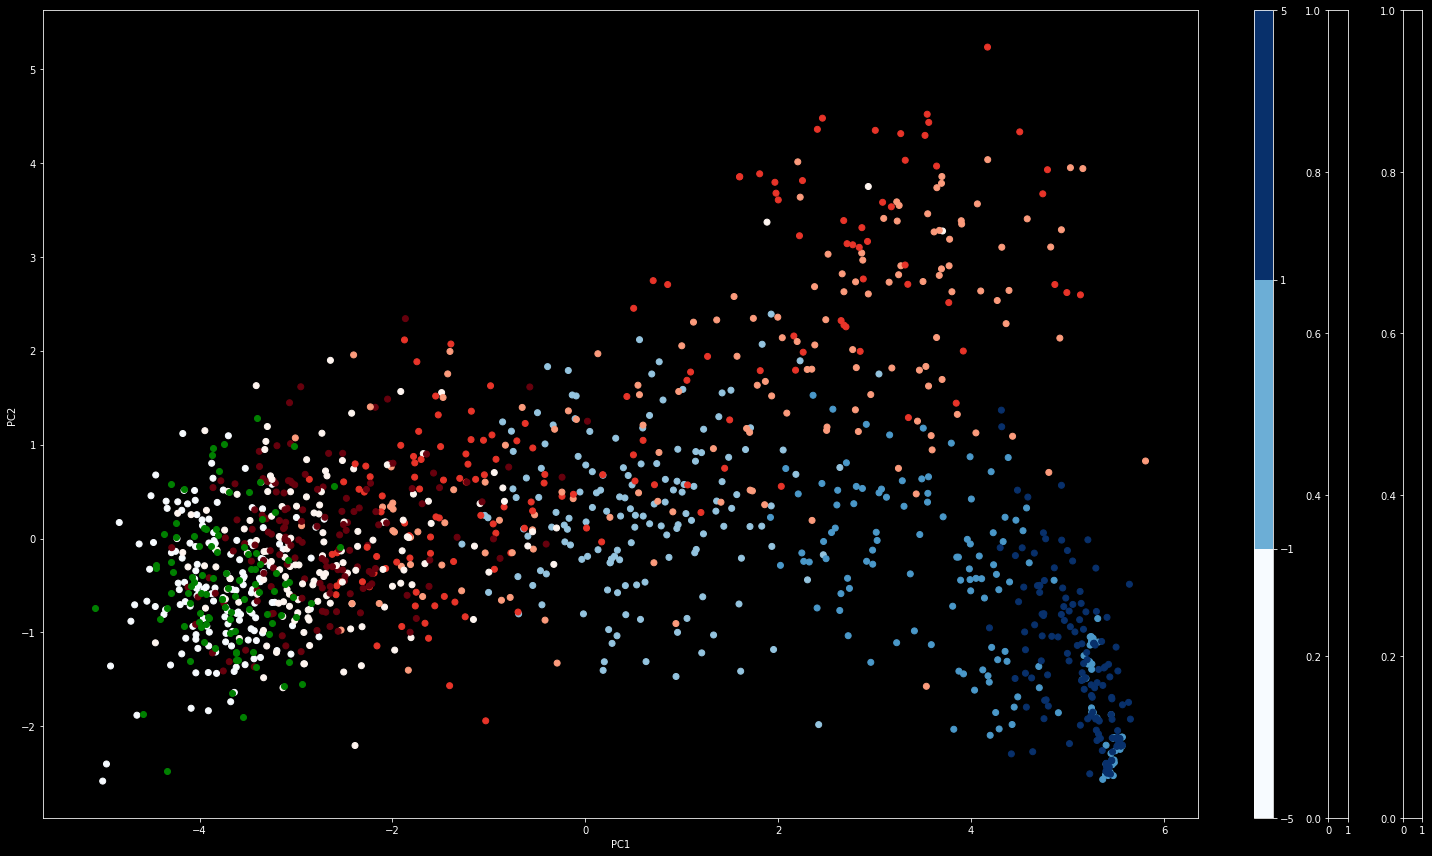

In [70]:
fig, (ax, cax1, cax2, cax3) = plt.subplots(ncols=4,figsize=(20,12), 
                  gridspec_kw={"width_ratios":[1.5, 0.025, 0.025, 0.025]})
cmap_hopf = palettable.colorbrewer.sequential.Blues_9.mpl_colormap
bounds_hopf = [-5, -1, 1, 5]
norm = mpl.colors.BoundaryNorm(bounds_hopf, cmap_hopf.N)
ax.scatter(hopf_trace[0], hopf_trace[1], c=hopf_trace['mu'], cmap=cmap_hopf, label='Hopf')
cba = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_hopf), cax=cax1, ticks=bounds_hopf)



cmap_bistable = palettable.colorbrewer.sequential.Reds_9.mpl_colormap
ax.scatter(bistable_trace[0], bistable_trace[1], c=bistable_trace['mu'], cmap=cmap_bistable, label='Bistable')
ax.scatter(hookes_trace[0], hookes_trace[1], c='g', label='Hookes')
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#          fancybox=True, shadow=True, ncol=3, markerscale=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
fig.tight_layout()
plt.show()